In [0]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

In [2]:
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [0]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

(99999, 2)
(99999,)


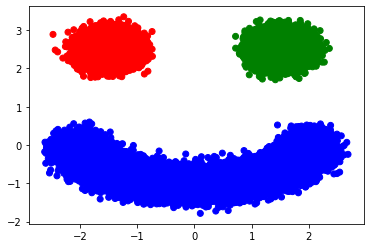

In [4]:
X, Y = sample_data_3()
print(X.shape)
print(Y.shape)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=matplotlib.colors.ListedColormap(['red','green','blue']))
plt.show()

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)
x_train, x_test, y_train, y_test = torch.FloatTensor(x_train), torch.FloatTensor(x_test), torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [0]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.n_features = 512
        self.n_layers = 5
        self.layers = nn.ModuleList()
        
        self.inlayer = nn.Linear(2, self.n_features)
        for i in range(3):
            self.layers.append(nn.Linear(512, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 4)
            
    def forward(self, x):
        x = torch.relu(self.inlayer(x))
        for layer in self.layers:
            x = torch.relu(layer(x)) + x
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = EncoderDecoder()
        self.decoder = EncoderDecoder()
        self.distr = MultivariateNormal(torch.zeros(2), torch.diag_embed(torch.ones(2)))
    
    def forward(self, x):
        mu_z, var_z = self.encoder(x)
        z = self.sample_normal(mu_z, var_z)
        mu_x, var_x = self.decoder(z)
        return mu_z, var_z, z, mu_x, var_x
      
    def loss(self, x):
        mu_z, var_z, z, mu_x, var_x = self.forward(x)
        nll = torch.sum(-0.5 * (torch.log(np.pi * 2 * var_x) + torch.pow(x - mu_x, 2) / var_x), dim=1, keepdim=True)
        nll = -torch.sum(nll, dim=1, keepdim=True)
        kl = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
        kl = -0.5 * torch.sum(kl, dim=1, keepdim=True)
        return nll, kl

    def sample(self, n):
        z = self.distr.rsample((n,)).to(DEVICE)
        mu_x, var_x = self.decoder(z)
        x = self.sample_normal(mu_x, var_x)
        return x, mu_x, var_x

    def sample_normal(self, mu, var):
      return mu + torch.randn(mu.shape).cuda() * torch.sqrt(var)

In [0]:
def train(vae, train_data, test_data, epochs_cnt):
    optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4)
    dataloader = DataLoader(train_data, batch_size=10000, shuffle=True)
    val_data = test_data.to(DEVICE)

    nll_values = {'train': [], 'val': []}
    kl_values = {'train': [], 'val': []}
    vlb_values = {'train': [], 'val': []}

    step = 0
    start = time.time()
    for i in range(epochs_cnt):
        for batch in dataloader:
            vae.train()
            step += 1
            batch = batch.to(DEVICE)
            nll, kl = vae.loss(batch)
            loss = torch.mean(nll + kl)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
            optimizer.step()

            nll_values['train'].append(torch.mean(nll).detach().item() / 2.0 / np.log(2))
            kl_values['train'].append(torch.mean(kl).detach().item())
            vlb_values['train'].append(torch.mean(-loss).detach().item())
            
            if step % 4 == 0:
                vae.eval()
                with torch.no_grad():
                    nll, kl = vae.loss(val_data)
                    loss = torch.mean(nll + kl)
                    nll_values['val'].append(torch.mean(nll).detach().item() / 2.0 / np.log(2))
                    kl_values['val'].append(torch.mean(kl).detach().item())
                    vlb_values['val'].append(torch.mean(-loss).detach().item())
                vae.train()
        if (i + 1) % 100 == 0:
            print(str(i + 1) + " epoch")
    return nll_values, kl_values, vlb_values

In [0]:
model = VAE().to(DEVICE)

In [10]:
nll, kl, vlb = train(model, x_train, x_test, epochs_cnt=5000)

2300 epoch
2400 epoch
2500 epoch
2600 epoch
2700 epoch
2800 epoch
2900 epoch
3000 epoch
3100 epoch
3200 epoch
3300 epoch
3400 epoch
3500 epoch
3600 epoch
3700 epoch
3800 epoch
3900 epoch
4000 epoch
4100 epoch
4200 epoch
4300 epoch
4400 epoch
4500 epoch
4600 epoch
4700 epoch
4800 epoch
4900 epoch
5000 epoch


In [0]:
def plot(train_values, val_values, label):
    plt.title(label)
    plt.plot(np.arange(1, len(train_values) + 1), train_values, label='Train')
    plt.plot(np.arange(1, len(val_values) + 1) * 4, val_values, label='Validation')
    plt.legend()
    plt.show()

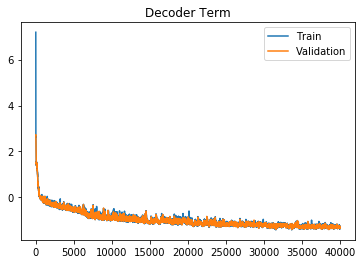

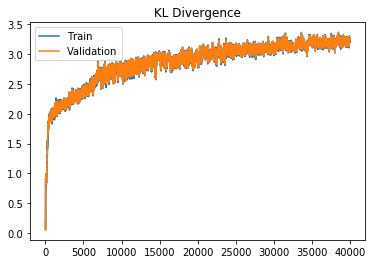

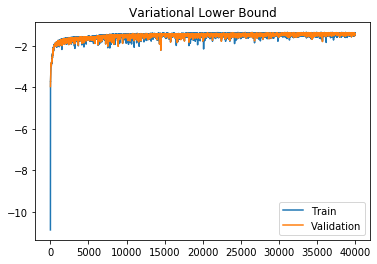

In [12]:
plot(nll['train'], nll['val'], 'Decoder Term')
plot(kl['train'], kl['val'], 'KL Divergence')
plot(vlb['train'], vlb['val'], 'Variational Lower Bound')

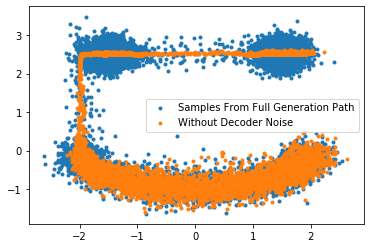

In [13]:
x, mu_x, var_x = model.sample(10000)
x = x.cpu().detach().numpy()
mu_x = mu_x.cpu().detach().numpy()
plt.scatter(x[:, 0], x[:, 1], marker='.', label="Samples From Full Generation Path")
plt.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label="Without Decoder Noise")
plt.legend()